In [1]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectKBest, chi2

# Classification - Predict job categories

- Identify features that can distinguish different job titles

## Import files

In [2]:
data = ('./seek_jobs_clean_17_Sept.csv')
df = pd.read_csv(data)

In [3]:
df.head(1)

,Unnamed: 0,city,date_posted,description,employer,type,industry,job_search_key,locality,title,url
0,0,Melbourne,2017-09-16T14:00:00Z,About us\nCrypton Analytics is a high performi...,Crypton Analytics,Full Time,Science & Technology,data-scientist,CBD & Inner Suburbs,Data Scientist (Cryptocurrency),https://www.seek.com.au/job/34374593


In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)

## Text Cleaning

### Clean description column

In [5]:
df['description'] = df['description'].str.replace('\n',' ')
#df['description'] = df['description'].map(lambda x : x.lower())

In [6]:
df['all'] = df['city'] + " " + df['description'] + " " + df['type'] + " " + df['title']

In [7]:
df = df.drop('locality', axis=1)

In [8]:
df.description = df.description.dropna()

In [9]:
df = df[~df['job_search_key'].isin(['statistician'])]
df['job_search_key'].unique()

array(['data-scientist', 'data-analyst', 'business-intelligence',
       'business-analyst', 'data-architect', 'data-engineer',
       'research-scientist', 'analyst'], dtype=object)

In [10]:
df.dropna(axis = 0, inplace=True)

## Describe data

In [11]:
df['job_search_key'].unique()

array(['data-scientist', 'data-analyst', 'business-intelligence',
       'business-analyst', 'data-architect', 'data-engineer',
       'research-scientist', 'analyst'], dtype=object)

### Count number of job ads per job search key

In [12]:
df['count'] = 1
job_groups = df.groupby('job_search_key').sum()
job_groups

,count
job_search_key,
analyst,262
business-analyst,395
business-intelligence,264
data-analyst,218
data-architect,109
data-engineer,121
data-scientist,156
research-scientist,27


### Visualise job ads per job search key

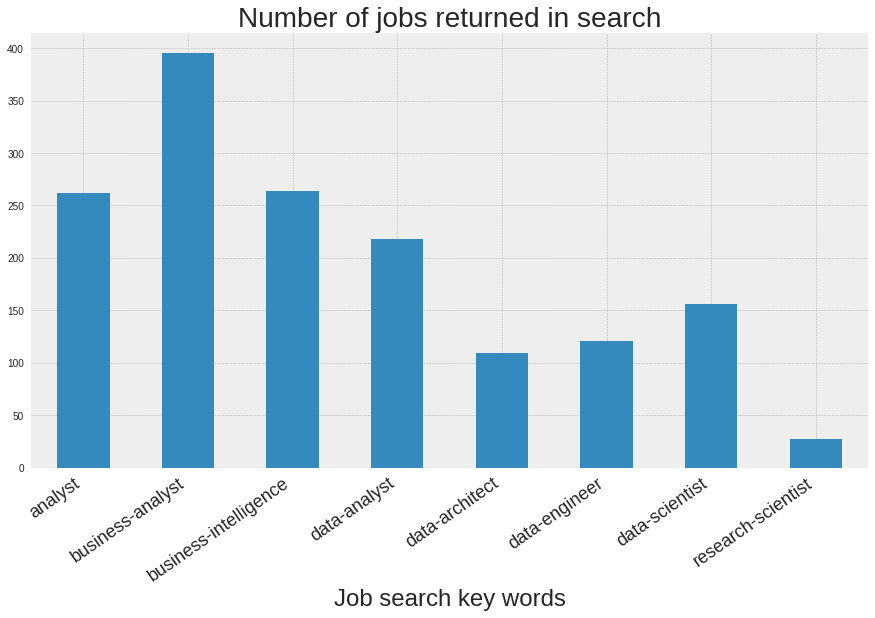

In [13]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(15,8))
job_groups.plot(kind='bar', legend=False, ax=ax) 
plt.xticks(rotation=35, fontsize=18);

ax.set_xlabel('Job search key words', fontsize=24);
plt.title('Number of jobs returned in search', fontsize=28);
#plt.plot([0-50,150], [200,200], 'lightblue', lw=2)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('right')

### Count number of jobs per location

In [14]:
city_job_search_group = df[['city','job_search_key','count']].groupby(['city','job_search_key']).sum()#.sort_values('count', ascending=False)
city_job_search = city_job_search_group.reset_index()
city_job_search.set_index('job_search_key', inplace=True)
city_job_search_group

count
city      job_search_key              
Adelaide  analyst                   50
          business-analyst          31
          business-intelligence     16
          data-analyst              10
          data-architect             2
          data-engineer              3
          data-scientist             6
Brisbane  analyst                   47
          business-analyst          86
          business-intelligence     59
          data-analyst              26
          data-architect            10
          data-engineer             10
          data-scientist             6
          research-scientist         2
Melbourne analyst                   56
          business-analyst          95
          business-intelligence     78
          data-analyst              83
          data-architect            39
          data-engineer             45
          data-scientist            46
          research-scientist        10
Perth     analyst                   41
          business-analyst          85
          business-intelligence     27
          data-analyst               8
          data-architect             5
          data-engineer              8
          data-scientist             7
Sydney    analyst                   68
          business-analyst          98
          business-intelligence     84
          data-analyst              91
          data-architect            53
          data-engineer             55
          data-scientist            91
          research-scientist        15

### Visualise number of jobs per location

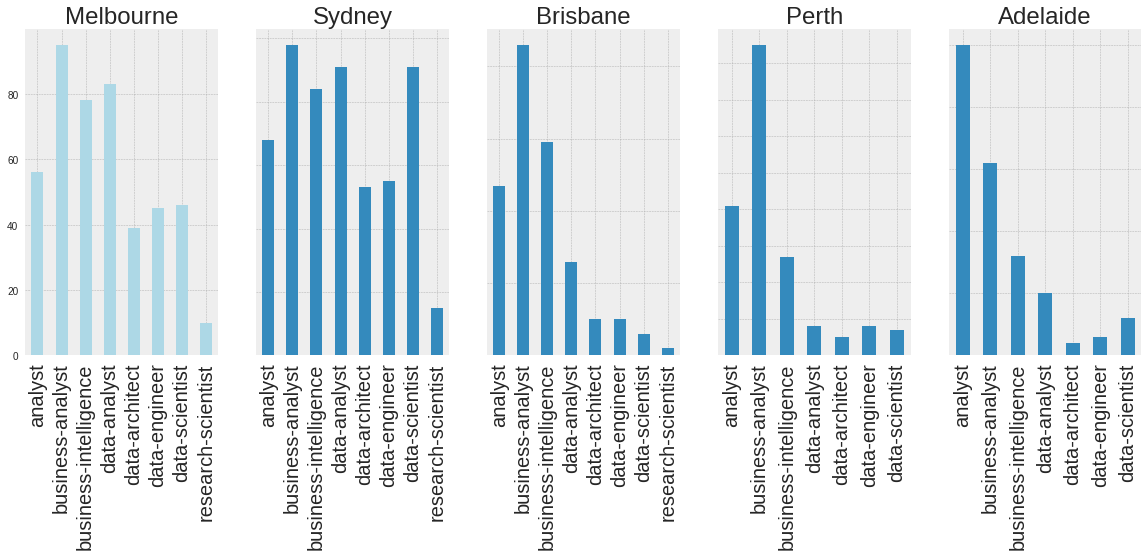

In [15]:
plt.style.use(['bmh'])
fig = plt.subplots(figsize=(20,6))

ax1 = plt.subplot(1,5,1)
city_job_search[city_job_search['city'] == 'Melbourne'].plot(kind='bar', ax = ax1, 
                                                             legend=False, sharey=True, color='lightblue')
plt.xticks(verticalalignment='top', fontsize=20)
plt.title('Melbourne', fontsize=24)
plt.xlabel('')

ax2 = plt.subplot(1,5,2)
city_job_search[city_job_search['city'] == 'Sydney'].plot(kind='bar', ax = ax2, legend=False, sharey=True)
plt.xticks(verticalalignment='top', fontsize=20)
plt.title('Sydney', fontsize=24)
plt.xlabel('')

ax3 = plt.subplot(1,5,3)
city_job_search[city_job_search['city'] == 'Brisbane'].plot(kind='bar', ax = ax3, legend=False, sharey=True)
plt.xticks(fontsize=20)
plt.title('Brisbane', fontsize=24)
plt.xlabel('')

ax4 = plt.subplot(1,5,4)
city_job_search[city_job_search['city'] == 'Perth'].plot(kind='bar', ax = ax4, legend=False, sharey=True)
plt.xticks(fontsize=20)
plt.title('Perth', fontsize=24)
plt.xlabel('')

ax5 = plt.subplot(1,5,5)
city_job_search[city_job_search['city'] == 'Adelaide'].plot(kind='bar', ax = ax5, legend=False, sharey=True)
plt.xticks(fontsize=20)
plt.title('Adelaide', fontsize=24)
plt.xlabel('')

#plt.tight_layout()

# Text evaluation

## Define stopwords

In [16]:
custom =  ["00" , "00005jab" , "00005jw6" , "00005k6w" , "00005kdi" , "00005ko7" , "00005krh" , "0009" , "001" , "0043228" , "0090mw" , "00pm" , "00pmfull" , "017" , "0197db" , "0216" , "022" , "023" , "0233" , "024" ,
           "0265" , "0280790962" , "0282" , "0282467740" , "0282467740full" , "0282512105" , "0282935000" , "0289863147" , "0292406382" , "0292406382contract" , "0292581121" , "0295656264" , "0299" , "0299931023" , "0299931072" , "0299931072full" , "0383191231" , "0383191236" , "0385" , "0386133557" , "0396044805" , "0399828478" , "0399828478full" , "0400" , "0402" , "0403" , "0404" , "0405" , "0408" , "0409" , "0411" , "0412" , "0413004657" , "0418" , "0420" , "0422015130" , "0422015130contract" , "0431" , "0434" , "0437" , "0448" , "04574" , "0470" , "0475" , "0481" , "0484" , "0487" , "0522" , "05229" , "0526" , "0566" , "0609" , "0613" , "07" , "071" , "08" , "0817" , "0900" , "0905" , "0917" , "0919" , "0934" , "093788bp" , "093788bpfull" , "097" , "099",  "1006" , "1007" , "100k" , "100s" , "102" , "1025" , "1029" , "1029full", "106" , "1068" , "107" , "108" , "1080" , "109" , "109k" , "10am" , "10tb" , "1100" , "1114131210bp" , "1114131210bpfull" , "113" , "115" , "116" , "117" , "1172" , "1175" , "118" , "119" , "11g" , "11pm"  , "1200" , "120k" , "121" , "122" , "125k" , "1261" , "1263" , "128" , "12878" , "128k" , "129" , "12c"  , "13" , "130" , "1300" , "1300835723" , "130k" , "135" , "135k" , "136" , "13cabs" ,  "1401" , "1405" , "140k" , "1436" , "146" , "148"  , "150" ,  "151" , "156" , "1566" , "15664" , "15665" , "157" , "15713" , "15755" , "15764" , "15770" , "15775" , "15781" , "160" , "1633" , "163m" , "1698" , "170" , "1708" , "1709" , "170k" , "175" , "175k" , "178" , "17full" , "18" , "180" , "1800" , "1809" , "1809full" , "1810full" , "182" , "1845" , "1855" , "1860" , "187" , "1888" , "1897" , "18th" , "19" , "190" , "1903" , "1911" , "1919" , "192" , "1950" , "1960" , "1967" , "1969" , "1970s" , "1974" , "1978" , "1979" , "1987" , "1988" , "1991" , "1994" , "1995" , "1997" , "1998" , "1999" , "19th" , "1m" , "1mb" , "1pm" , "1q" , "1st" , "20" , "200" , "2000" , "2001" , "200167575" , "200169426" , "200169552" , "200170452" , "200170453" , "200171184" , "200171227" , "200171228" , "200171283" , "200171322" , "200171371" , "200171391" , "200171419" , "200171439" , "2002" , "20022" , "2003964" , "2003964contract" , "2005" , "2006" , "2007" , "2008" , "2008r2" , "200k" , "2010" , "2011" , "2012" , "2012r3" , "2013" , "2014" , "2015" , "2016" , "20170860" , "20170861" , "20170862" , "20170863" , "2017contract" , "2017full" , "2018" , "2020" , "202017" , "2025" , "2036" , "2070" , "20august" , "20k" , "20mw" , "20officer" , "20pd" , "20project" , "20th" , "21" , "211" , "2111" , "2143" , "21c" , "22" , "220" , "2223" , "2223contract" , "2224" , "223" , "2232" , "2234" , "2278" , "2278contract" , "229" , "229555" , "22nd" , "23" , "230" , "2310" , "231822" , "231946" , "232" , "232409" , "232805" , "232851" , "232934" , "232937" , "232947" , "2330" , "2351" , "238" , "24" , "2410" , "244" , "2453" , "25" , "250" , "250k" , "2566" , "2566contract" , "2596181" , "25km" , "25th" , "26" , "2602" , "2603" , "2612" , "262" , "2626" , "26276" , "2640" , "265" , "265856" , "2672" , "26th" , "27" , "27001" , "2777" , "278968" , "27th" , "28" , "280" , "29" , "290" , "291" , "293" , "2b" , "2d" , "2hxlv8i" , "2ic" , "2mb" , "2n" , "2nd" , "2r" , "2x3" , "2xm" , "2yrs" , "30" , "300" , "3000" , "300k" , "300m" , "3055" , "309" , "30am" , "30pm" , "31" , "3100" , "3105" , "3111" , "31245715" , "31245740" , "3139" , "3147" , "316" , "3165" , "3171" , "3182" , "3183" , "31st" , "32" , "320" , "32201" , "3221" , "323" , "324" , "324full" , "33" , "3300" , "3311" , "3333" , "3365" , "3389" , "34" , "342" , "3439" , "3445" , "349" , "35" , "350million" , "3515" , "358" , "359" , "36" , "360" , "3605" , "3631" , "365" , "3661" , "369" , "369full" , "37" , "3721" , "37971" , "3799" , "38" , "38528" , "387" , "38952lc" , "3926" , "3926contract" , "3940" , "3d" , "3dme" , "3mth" , "3nd" , "3nf" , "3pl" , "3pm" , "3rd" , "3yrs" , "40" , "400" , "4000" , "400k" , "400per" , "4055" , "407" , "409" , "412" , "415774" , "42" , "420" , "4202" , "4204" , "4206" , "4214" , "4215" , "4222contract" , "4222full" , "4223" , "4231" , "426" , "4279" , "4279full" , "4290" , "43" , "437" , "4450" , "45" , "450" , "4500" , "4500contract" , "4510" , "45461" , "456" , "457" , "46" , "46267" , "465" , "46902" , "46903" , "46942" , "46943" , "46947" , "470" , "48" , "480" , "4822" , "483" , "4867" , "4880" , "4927" , "496" , "496full" , "499496" , "499678" , "4bn" , "4pl" , "4th" , "4yrs" , "500" , "5000" , "500381" , "500k" , "5011" , "5015" , "5017" , "50k" , "50lbs" , "50th" , "511" , "5126" , "514554" , "515" , "5218" , "53" , "547" , "54883" , "54883contract" , "55" , "550" , "551" , "5554" , "55pm" , "562" , "5628" , "5661" , "5685" , "57" , "5715" , "5717" , "5783" , "5812" , "5832" , "589" , "597" , "59pm" , "5pm" , "5pmpart" , "5th" , "5yrs" , "60" , "600" , "601" , "6020" , "60ml" , "61" , "6103" , "6114" , "6124" , "6126" , "613" , "6299" , "63" , "630" , "64" , "6400" , "642" , "648" , "65" , "650" , "6500" , "6500contract" , "6519" , "6519full" , "6521" , "6522" , "6524" , "6528" , "656" , "656per" , "661" , "662" , "663" , "6660" , "6737" , "679" , "68" , "6801" , "6801full" , "6806" , "6806contract" , "6807" , "6807contract" , "6807full" , "6809" , "6809casual" , "69" , "6905" , "695" , "69855br" , "6998" , "6mths" , "70" , "700" , "7000" , "7037" , "70k" , "7102" , "7114" , "720" , "7244" , "725" , "726" , "7370" , "739" , "744" , "749" , "75" , "751" , "754" , "7545" , "755" , "757" , "7582" , "7582casual" , "7589" , "7589full" , "7595" , "762" , "7629" , "763" , "77" , "7700" , "7701" , "7704" , "7705" , "7705full" , "7706" , "7708" , "7716" , "7718" , "7735" , "7737" , "775" , "78" , "7808" , "7815" , "782601" , "789" , "791" , "7910" , "793" , "7th" , "7yrs" , "80" , "800" , "8005" , "8008" , "8015" , "8016" , "802" , "8020" , "8032" , "8033" , "8041" , "805" , "8055" , "8071" , "8076" , "808" , "8080" , "8089" , "8093" , "80k" , "8103" , "8160" , "820" , "8200" , "8228" , "82324419" , "8240" , "82436808" , "8245" , "8246" , "82467702" , "8247" , "8248" , "82489800" , "8252" , "82523120" , "8256" , "8270" , "8274" , "8281" , "8289" , "82893232" , "82893256" , "8296" , "830" , "83005003" , "8319" , "8320" , "8330" , "83305003" , "8333" , "8346" , "836" , "8373" , "8399" , "8404" , "8404contract" , "84058000" , "84058000full" , "8423" , "84231005" , "84231033" , "8458" , "848" , "84829" , "8500" , "8500full" , "8503" , "8503full" , "8506" , "8527" , "8535" , "85359" , "8574" , "85k" , "86" , "8600" , "8613" , "8620" , "8623" , "8625" , "8627" , "8628" , "8629" , "86291015" , "86291015contract" , "8632" , "8637" , "8663" , "8667" , "8676" , "868" , "8680" , "86804220" , "86804240" , "8699" , "87" , "8705" , "8709" , "872" , "8741" , "8745" , "8768" , "8787" , "881" , "8811" , "882" , "8836" , "8837" , "8850" , "8877" , "8899" , "895" , "8952" , "8967" , "8986" , "8yrs" , "90" , "900" , "9000" , "9020" , "9021" , "9032" , "9037" , "9076" , "9081" , "9088" , "9094" , "9097" , "90k" , "90m0319052" , "90m0319052contract" , "90m0319832" , "90m0319832contract" , "91" , "9103" , "9114" , "9122762jo" , "9122762jofull" , "9122763jo" , "9122763jofull" , "9140" , "9146" , "916" , "9195" , "91k" , "92" , "9200" , "9206" , "9214" , "92216422" , "92216422full" , "9233" , "9236" , "9238" , "9241" , "9245" , "9248" , "92486213" , "92486213full" , "9249" , "92498040" , "92498040contract" , "9259" , "92598775" , "9264" , "9266" , "927" , "9270" , "9274" , "9277" , "9279" , "93" , "931" , "9311" , "9334" , "9347" , "940270" , "9409" , "941" , "9411" , "9413" , "9431" , "9456" , "9460" , "9464" , "94645575" , "9470" , "9492" , "95" , "9500" , "9505" , "9514" , "9519" , "9523" , "9529" , "9535" , "9558" , "9569" , "9592" , "9598" , "95k" , "9600" , "9604" , "9606" , "9607" , "9617" , "9626" , "9629" , "96336958" , "9641" , "9652" , "9656" , "9658" , "9663" , "9682" , "9687" , "9691" , "9696" , "97" , "9700" , "9700full" , "9707" , "9710" , "9717" , "9718" , "978" , "9794" , "98" , "9800" , "9804" , "9807" , "9815" , "9815full" , "984" , "9855" , "9864" , "9888" , "9888full" , "9894" , "9896" , "99" , "9900" , "9907" , "99165819" , "9918" , "9929" , "9943" , "9949" , "9956" , "996" , "9968" , "99828462" , "99828462part" , "99828478contract" , "99828478full" , "9999" , "9am" , "9b", '000','8088','8227','03','04','1810','8848','87570003','9223','0292702600','99828478','0386804227','99828478','01contract',
          '01','33466832', 'counter','3414', '6113','3500' 'confidential','559' '15','plu', 'employ','76','784','81', '883','8282','89','559','8214', '6241','8216', '3500','8224', '3800','8306','883' '89','559','104','784','559','bourke','apply', 'button', 'please','x99','xa2','x99t','x93','x94','x98','this','https','x99s','www', 'http','3023','1024','quot','ref','3027','2556','3137','5111','3258','8356','james', 'bain','ref', 'jo','0477', '778', '449', 'quot','this','xc2', 'xb7', 'role', 'xe2', 'x80', 'experience', 'com', 'au', 'ability', 'communication', '02','1810','8292','0294645631','8641','9602','4222','132','140','12877','1178','50','0ba95a136','09','2017','053','077','253','0450']

In [17]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
#custom_stop_words = (ENGLISH_STOP_WORDS)
custom_stop_words = []
for x in ENGLISH_STOP_WORDS:
    custom_stop_words.append(x)

for c in custom:
    custom_stop_words.append(c)

#custom_stop_words = frozenset(custom_stop_words)

#custom_stop_words = text.ENGLISH_STOP_WORDS.union(custom)
custom_stop_words.sort()
#custom_stop_words

In [18]:
from nltk.stem import PorterStemmer,SnowballStemmer
stemmer = SnowballStemmer('english')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer() 

In [19]:
# Tokenize words in description
df['desc_tokenized'] = df['description'].apply(lambda x : filter(None,x.split(" ")))
# Lemmatize words
df['desc_lemmed'] = df['desc_tokenized'].apply(lambda x : [wordnet_lemmatizer.lemmatize(y) for y in x])
# Apply stemmer
df['desc_stemmed'] = df['desc_lemmed'].apply(lambda x : [stemmer.stem(y) for y in x])

## Fit_transform text with CountVectorize 

In [20]:
## Instantiate count vectorizer
cv = CountVectorizer(input='content',stop_words=custom_stop_words, analyzer='word', 
                     ngram_range=(2,6), min_df=3, lowercase=True)
## set features - X
X = df['desc_stemmed'].astype('U')

## fit count vectorizer to features
df_cv = cv.fit_transform(X)

## create df with sum of counts
docs = pd.DataFrame(df_cv.todense(), columns=cv.get_feature_names())

## add job_search key to df - will become y target
docs['job_search_key'] = df['job_search_key']

## Find most used words for each job search key
docs_group = docs.groupby('job_search_key').sum() 

## Define job keys
job_key = [job for job in df['job_search_key'].unique()]

## find the top most common words for each job search key - add to df
keep_words = [word for job in job_key for word in docs_group.T.sort_values(job_key, ascending=False)[:100].index]

## filter dense df for most common words
keep_words_df = docs[keep_words]

## Test/view df
#docs_group.T.sort_values('data-analyst', ascending=False).head(5)

In [21]:
## top 100 words for each job category
keep_words_df.shape, df.shape, docs.shape

((1552, 800), (1552, 14), (1552, 58298))

# Data modelling

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Ridge, Lasso

## instantiate label encoder 
le = preprocessing.LabelEncoder()

## Encode y target into numbers
y = le.fit_transform(df['job_search_key'])

## Add y to main df
df['target_job_label'] = y

### Fit logistic regression model only using keep_words data

In [23]:
## list of n_grams to search through
n_grams = [(1,2), (1,3), (1,4), (1,5), (1,6), (2,3), (2,4), (2,5),(2,6),(2,7),(3,4),(3,5),(3,6),(3,7),(4,5),(4,6),(4,7),(5,6),(5,7),(6,7)]
## Dataframe for results
df_lr = pd.DataFrame(index=range(0,len(n_grams)), columns=['ngrams', 'best penalty', 'score'])
idx = 0
print ('starting '),
## search through ngrams
for n in n_grams:
     
    # Instantiate count vectorizer
    cv = CountVectorizer(input='content',stop_words=custom_stop_words, analyzer='word', 
                         ngram_range=n, min_df=3, lowercase=True)
    ## set features - X
    X = df['desc_stemmed'].astype('U')

    ## fit count vectorizer to features
    df_cv = cv.fit_transform(X)

    ## create df with sum of counts
    docs = pd.DataFrame(df_cv.todense(), columns=cv.get_feature_names())

    ## add job_search key to df - will become y target
    docs['job_search_key'] = df['job_search_key']

    ## Find most used words for each job search key
    docs_group = docs.groupby('job_search_key').sum() 

    ## Define job keys
    job_key = [job for job in df['job_search_key'].unique()]

    ## find the top most common words for each job search key - add to df
    keep_words = [word for job in job_key for word in docs_group.T.sort_values(job_key, ascending=False)[:100].index]

    ## filter dense df for most common words
    X = docs[keep_words]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    parameters = {'penalty': ['l1','l2'],
                 }
    lr = LogisticRegression(n_jobs = -1, random_state=42)
    gr_lr = GridSearchCV(lr, parameters)

    lr_model = gr_lr.fit(X_train, y_train)
    score = lr_model.score(X_test, y_test)
    y_pred = lr_model.predict(X_test)

    df_lr.iloc[idx,0] = n
    df_lr.iloc[idx,1] = lr_model.best_params_.values()
    df_lr.iloc[idx,2] = score

    idx += 1
    print ('. '),
print ('completed')
df_lr

starting  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  completed


,ngrams,best penalty,score
0,"(1, 2)",[l1],0.615984
1,"(1, 3)",[l1],0.615984
2,"(1, 4)",[l1],0.615984
3,"(1, 5)",[l1],0.615984
4,"(1, 6)",[l1],0.615984
5,"(2, 3)",[l1],0.576998
6,"(2, 4)",[l1],0.576998
7,"(2, 5)",[l1],0.576998
8,"(2, 6)",[l1],0.576998
9,"(2, 7)",[l1],0.576998


Ngrams from 1 - 6 have the same score

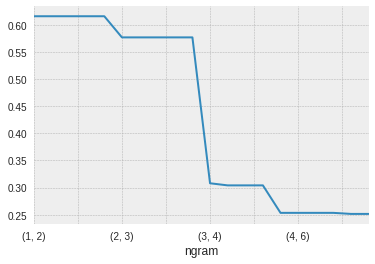

In [24]:
df_lr_in = df_lr.set_index('ngrams')
df_lr_in['score'].plot()
plt.xlabel('ngram');


### Fit logistic regression model using all words in description

In [25]:
## list of n_grams to search through
n_grams = [(1,2), (1,3), (1,4), (1,5), (1,6), (2,3), (2,4), (2,5),(2,6),(2,7),(3,4),(3,5),(3,6),(3,7),(4,5),(4,6),(4,7),(5,6),(5,7),(6,7)]
## Dataframe for results
df_lr_all = pd.DataFrame(index=range(0,len(n_grams)), columns=['ngrams', 'best penalty', 'score', 'y_pred','y_test'])
idx = 0
print ('starting '),
for n in n_grams:
    
    ## search through ngramsfor n in n_grams:
    cv = CountVectorizer(input='content',stop_words=custom_stop_words, analyzer='word', 
                     ngram_range=n, min_df=3, lowercase=True)
    
    ## Set X features
    X_all = cv.fit_transform(df['desc_stemmed'].astype('U'))

    ## Train test split data
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.33, random_state=42)

    parameters = {'penalty': ['l1','l2'],
                 }
    lr = LogisticRegression(n_jobs = -1, random_state=42)
    gr_lr = GridSearchCV(lr, parameters)
    lr_model = gr_lr.fit(X_train, y_train)
    score = lr_model.score(X_test, y_test)
    y_pred = lr_model.predict(X_test)

    df_lr_all.iloc[idx,0] = n
    df_lr_all.iloc[idx,1] = lr_model.best_params_.values()
    df_lr_all.iloc[idx,2] = score
    df_lr_all.iloc[idx,3] = y_pred
    df_lr_all.iloc[idx,4] = y_test
    idx += 1
    print ('. '),
print ('\ncompleted')

starting  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
completed


In [26]:
## print results 
df_lr_all[['ngrams','best penalty','score']].sort_values('score',ascending=False)

,ngrams,best penalty,score
0,"(1, 2)",[l1],0.805068
1,"(1, 3)",[l1],0.805068
2,"(1, 4)",[l1],0.805068
3,"(1, 5)",[l1],0.805068
4,"(1, 6)",[l1],0.805068
6,"(2, 4)",[l1],0.758285
5,"(2, 3)",[l1],0.756335
7,"(2, 5)",[l1],0.756335
8,"(2, 6)",[l1],0.756335
9,"(2, 7)",[l1],0.754386


ngrams 1,5 have the highest score with Lasso

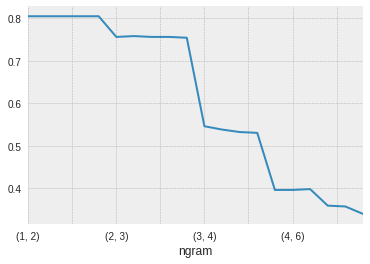

In [27]:
df_lr_all_in = df_lr_all.set_index('ngrams')
df_lr_all_in['score'].plot()
plt.xlabel('ngram');

## Other models using all words

In [28]:
## list of n_grams to search through
n_grams = [(1,2), (1,3), (1,4), (1,5), (1,6), (2,3), (2,4), (2,5),(2,6),(2,7),(3,4),(3,5),(3,6),(3,7),(4,5),(4,6),(4,7),(5,6),(5,7),(6,7)]
## Dataframe for results
#df_lr_test = pd.DataFrame(index=range(0,len(n_grams)), columns=['ngrams', 'best penalty', 'score', 'y_pred','y_test'])
idx = 0
print ('starting '),
for n in n_grams:
    print ('{} ngrams'.format(n))
    print ('- ') * 40
    # Instantiate count vectorizer
    cv = CountVectorizer(input='content',stop_words=custom_stop_words, analyzer='word', 
                         ngram_range=n, min_df=3, lowercase=True)
    ## set features - X
    X = df['desc_stemmed'].astype('U')

    ## Train test split data
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.33, random_state=42)

    ## fit count vectorizer to features
    df_cv = cv.fit_transform(X)

    ## Logistic Regression
    parameters = {'penalty': ['l1','l2']}
    lr = LogisticRegression(n_jobs = -1, random_state=42)
    gr_lr = GridSearchCV(lr, parameters)
    gr_lr.fit(X_train, y_train)
    lrscore = gr_lr.score(X_test, y_test)
    print ('{} - Logistic regression  | {}'.format( lrscore, gr_lr.best_params_))
    print ('=' *80)
    
    ## SGD
    sg = SGDClassifier(alpha=.0008, n_iter=50,penalty="elasticnet")
    sg.fit(X_train,y_train)
    sgscore = sg.score(X_test, y_test)
    print('{} - SGD score'.format(sgscore))
    print ('=' *80)
    
    ## Ridge 
    rg = RidgeClassifier(alpha=1)
    rg.fit(X_train, y_train)
    rgscore = rg.score(X_test, y_test)
    #rg_y_pred = rg.predict(X_test)
    print ('{} - Ridge '.format(rgscore))
    print ('=' *80)
    
    ## Random forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rfscore = rf.score(X_test, y_test)
    #rf_y_pred = rf.predic(vec_X_text)
    print ('{} - Random forest '.format(rfscore))
    print ('=' *80)
    
    ## Naive Bayes
    mnb = MultinomialNB(alpha=.01)
    mnb.fit(X_train, y_train)
    mnbscore = mnb.score(X_test, y_test)
    print ('{} - NB Multinomial'.format(mnbscore))
    print ('=' *80)
    
    bnb = BernoulliNB(alpha=.01)
    bnb.fit(X_train, y_train)
    bnbscore = bnb.score(X_test, y_test)
    print ('{} - NB Bernoulli\n'.format(bnbscore, n))
    print ('=' *80)
    idx += 1
    
print ('\ncompleted')

starting  (1, 2) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.33918128655 - Logistic regression  | {'penalty': 'l2'}
0.337231968811 - SGD score
0.327485380117 - Ridge 
0.335282651072 - Random forest 
0.348927875244 - NB Multinomial
0.343079922027 - NB Bernoulli

(1, 3) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.33918128655 - Logistic regression  | {'penalty': 'l2'}
0.337231968811 - SGD score
0.327485380117 - Ridge 
0.335282651072 - Random forest 
0.348927875244 - NB Multinomial
0.343079922027 - NB Bernoulli

(1, 4) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.33918128655 - Logistic regression  | {'penalty': 'l2'}
0.2261208577 - SGD score
0.327485380117 - Ridge 
0.335282651072 - Random forest 
0.348927875244 - NB Multinomial
0.343079922027 - NB Bernoulli

(1, 5) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.3

0.335282651072 - Random forest 
0.348927875244 - NB Multinomial
0.343079922027 - NB Bernoulli

(3, 5) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.33918128655 - Logistic regression  | {'penalty': 'l2'}
0.335282651072 - SGD score
0.327485380117 - Ridge 
0.335282651072 - Random forest 
0.348927875244 - NB Multinomial
0.343079922027 - NB Bernoulli

(3, 6) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.33918128655 - Logistic regression  | {'penalty': 'l2'}
0.343079922027 - SGD score
0.325536062378 - Ridge 
0.335282651072 - Random forest 
0.348927875244 - NB Multinomial
0.343079922027 - NB Bernoulli

(3, 7) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.33918128655 - Logistic regression  | {'penalty': 'l2'}
0.343079922027 - SGD score
0.327485380117 - Ridge 
0.335282651072 - Random forest 
0.348927875244 - NB Multinomial
0.343079922027 - NB Bernoulli

(4, 5) ngra

## Models using Term frequency and SelectKbest

In [29]:
## list of n_grams to search through
n_grams = [(1,2), (1,3), (1,4), (1,5), (1,6), (2,3), (2,4), (2,5),(2,6),(2,7),(3,4),(3,5),(3,6),(3,7),(4,5),(4,6),(4,7),(5,6),(5,7),(6,7)]
## Dataframe for results
#df_lr_test = pd.DataFrame(index=range(0,len(n_grams)), columns=['ngrams', 'best penalty', 'score', 'y_pred','y_test'])
idx = 0
print ('starting '),
for n in n_grams:
    print ('{} ngrams'.format(n))
    print ('- ') * 40


    ## With Feature selection
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                     stop_words='english', lowercase=False)

    ## Set X features
    X = df['desc_stemmed'].astype('U')

    ## Train test split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

    ## fit X to vectorizer
    vec_X_train = vectorizer.fit_transform(X_train)
    vec_X_test = vectorizer.transform(X_test)

    feature_names = vectorizer.get_feature_names()

    ch2 = SelectKBest(chi2, 100)
    ch_X_train = ch2.fit_transform(vec_X_train, y_train)
    ch_X_test = ch2.transform(vec_X_test)

    ## Logistic Regression

    parameters = {'penalty': ['l1','l2'],
                     }
    lr = LogisticRegression(n_jobs = -1, random_state=42)
    gr_lr = GridSearchCV(lr, parameters)

    gr_lr.fit(vec_X_train, y_train)
    lrscore = gr_lr.score(vec_X_test, y_test)

    print ('{} - Logistic regression | {}'.format(lrscore, gr_lr.best_params_))
    print ('=' *80)
    ## SGD
    sg = SGDClassifier(alpha=.0008, n_iter=50,penalty="elasticnet")
    sg.fit(vec_X_train,y_train)
    sgscore = sg.score(vec_X_test, y_test)
    print ('{} - SGD '.format(sgscore))
    print ('=' *80)
    ## Ridge 
    rg = RidgeClassifier(alpha=1)
    rg.fit(vec_X_train, y_train)
    score = rg.score(vec_X_test, y_test)
    #rg_y_pred = rg.predict(vec_X_test)
    print ('{} - Ridge'.format(score))
    print ('=' *80)
    ## Random forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(vec_X_train, y_train)
    score = rf.score(vec_X_test, y_test)
    #rf_y_pred = rf.predic(vec_X_text)
    print ('{} - Random forest'.format(score))
    print ('=' *80)
    ## Naive Bayes
    mnb = MultinomialNB(alpha=.01)
    mnb.fit(vec_X_train, y_train)
    mnbscore = mnb.score(vec_X_test, y_test)
    print ('{} - NB Multinomial'.format(mnbscore))
    print ('=' *80)
    bnb = BernoulliNB(alpha=.01)
    bnb.fit(vec_X_train, y_train)
    bnbscore = bnb.score(vec_X_test, y_test)
    print ('{} - NB Bernoulli'.format( bnbscore))
    print ('=' *80)
    idx += 1
    
print ('\ncompleted')

starting  (1, 2) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.561855670103 - Logistic regression | {'penalty': 'l1'}
0.66881443299 - SGD 
0.657216494845 - Ridge
0.561855670103 - Random forest
0.537371134021 - NB Multinomial
0.52706185567 - NB Bernoulli
(1, 3) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.561855670103 - Logistic regression | {'penalty': 'l1'}
0.666237113402 - SGD 
0.658505154639 - Ridge
0.561855670103 - Random forest
0.537371134021 - NB Multinomial
0.52706185567 - NB Bernoulli
(1, 4) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.561855670103 - Logistic regression | {'penalty': 'l1'}
0.664948453608 - SGD 
0.657216494845 - Ridge
0.561855670103 - Random forest
0.537371134021 - NB Multinomial
0.52706185567 - NB Bernoulli
(1, 5) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.561855670103 - Logistic reg

0.561855670103 - Random forest
0.537371134021 - NB Multinomial
0.52706185567 - NB Bernoulli
(3, 5) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.561855670103 - Logistic regression | {'penalty': 'l1'}
0.662371134021 - SGD 
0.657216494845 - Ridge
0.561855670103 - Random forest
0.537371134021 - NB Multinomial
0.52706185567 - NB Bernoulli
(3, 6) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.561855670103 - Logistic regression | {'penalty': 'l1'}
0.666237113402 - SGD 
0.657216494845 - Ridge
0.561855670103 - Random forest
0.537371134021 - NB Multinomial
0.52706185567 - NB Bernoulli
(3, 7) ngrams
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0.561855670103 - Logistic regression | {'penalty': 'l1'}
0.666237113402 - SGD 
0.657216494845 - Ridge
0.561855670103 - Random forest
0.537371134021 - NB Multinomial
0.52706185567 - NB Bernoulli
(4, 5) ngrams
- - - - - - - - - - - - - -

# Further exploring best model - Logistic regression with Lasso

In [30]:

cv = CountVectorizer(input='content',stop_words=custom_stop_words, analyzer='word', 
                 ngram_range=(1,5), min_df=3, lowercase=True)

## Set X features
X_all = cv.fit_transform(df['desc_stemmed'].astype('U'))

## Train test split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.33, random_state=42)

lr = LogisticRegression(n_jobs = -1, random_state=42, penalty='l1')

lr_model = lr.fit(X_train, y_train)
score = lr_model.score(X_test, y_test)
y_pred = lr_model.predict(X_test)
print score
print(metrics.classification_report(df_lr_all['y_test'][3], df_lr_all['y_pred'][3]))
# treats instances equally
print('Micro average precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred, average='micro')))
# treats classes equally
print('Macro average precision: {:.2f}'.format(metrics.precision_score(y_test,y_pred, average='macro')))

0.805068226121
             precision    recall  f1-score   support

          0       0.77      0.76      0.77       102
          1       0.80      0.88      0.84       129
          2       0.77      0.85      0.81        72
          3       0.84      0.75      0.79        77
          4       0.94      0.78      0.85        37
          5       0.74      0.69      0.71        51
          6       0.90      0.90      0.90        41
          7       0.50      0.50      0.50         4

avg / total       0.81      0.81      0.80       513

Micro average precision: 0.81
Macro average precision: 0.78


## Confusion matrix

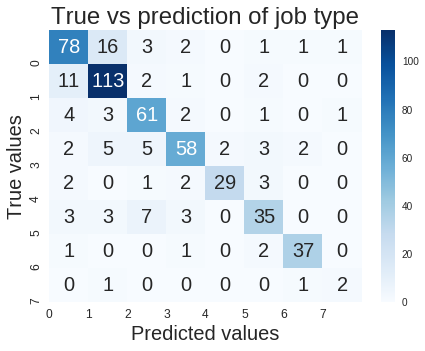

In [39]:
fig, ax = plt.subplots(figsize=(7,5))
cm = confusion_matrix(df_lr_all['y_test'][3], df_lr_all['y_pred'][3])
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d',annot_kws={"size": 20})
ticks = np.linspace(0, 8,num=9)
plt.xticks(ticks, fontsize=12)
plt.yticks(ticks, fontsize=12)
plt.grid(False)
plt.ylabel('True values', fontsize=20)
plt.xlabel('Predicted values', fontsize=20)
plt.title('True vs prediction of job type', fontsize=24)
plt.show()

In [61]:
from __future__ import  division
## True numbers predicted
print ('analyst correctly predicted {:2f}% of the time'.format(cm[0][0] / cm[0].sum()))
print ('business-analyst correctly predicted {:2f}% of the time'.format(cm[1][1] / cm[1].sum()))   
print ('business-intelligence correctly predicted {:2f}% of the time'.format(cm[2][2] / cm[2].sum()))
print ('data-analyst correctly predicted {:2f}% of the time'.format(cm[3][3] / cm[3].sum()))
print ('data-architect correctly predicted {:2f}% of the time'.format(cm[4][4] / cm[4].sum()))
print ('data-engineer correctly predicted {:2f}% of the time'.format(cm[5][5] / cm[5].sum()))
print ('data-scientist correctly predicted {:2f}% of the time'.format(cm[6][6] / cm[6].sum()))
print ('research-scientist correctly predicted {:2f}% of the time'.format(cm[7][7] / cm[7].sum()))


analyst correctly predicted 0.764706% of the time
business-analyst correctly predicted 0.875969% of the time
business-intelligence correctly predicted 0.847222% of the time
data-analyst correctly predicted 0.753247% of the time
data-architect correctly predicted 0.783784% of the time
data-engineer correctly predicted 0.686275% of the time
data-scientist correctly predicted 0.902439% of the time
research-scientist correctly predicted 0.500000% of the time


In [62]:
# predicted numbers true
print ('Predictions for analyst were correct {:2f}% of the time'.format(cm[:,0][0] / cm[:,0].sum()))
print ('Predictions for business-analyst were correct {:2f}% of the time'.format(cm[:,1][1] / cm[:,1].sum()))
print ('Predictions for business-intelligence were correct {:2f}% of the time'.format(cm[:,2][2] / cm[:,2].sum()))
print ('Predictions for data-analyst were correct {:2f}% of the time'.format(cm[:,3][3] / cm[:,3].sum()))
print ('Predictions for data-architect were correct {:2f}% of the time'.format(cm[:,4][4] / cm[:,4].sum()))
print ('Predictions for data-engineer were correct {:2f}% of the time'.format(cm[:,5][5] / cm[:,5].sum()))
print ('Predictions for data-scientist were correct {:2f}% of the time'.format(cm[:,6][6] / cm[:,6].sum()))
print ('Predictions for research-scientist were correct {:2f}% of the time'.format(cm[:,7][7] / cm[:,7].sum()))


Predictions for analyst were correct 0.772277% of the time
Predictions for business-analyst were correct 0.801418% of the time
Predictions for business-intelligence were correct 0.772152% of the time
Predictions for data-analyst were correct 0.840580% of the time
Predictions for data-architect were correct 0.935484% of the time
Predictions for data-engineer were correct 0.744681% of the time
Predictions for data-scientist were correct 0.902439% of the time
Predictions for research-scientist were correct 0.500000% of the time


--------------------

# Attempt to predict salary from payscale.com and seek.com data

In [ ]:
salary_words = ['Entry Level', 'Microsoft','Office', 'Access', 'Excel', 'Tableau', 'Data' , 'Analysis', 'R', 'Modeling', 'SAS', 'Late Career', 'SQL', 'Server', 'SPSS', 'Experienced', 'Mid Career', 'SAS', 'Visual Basic','VB', 'Windows','OS', 'Business Analysis', 'Intelligence', 'Process','Engineering', 'Business Objects', 'Chemistry', 'Clinical','Research', 'Cognos', 'Warehouse', 'Database Management' ,'Reporting', 'Financial', 'Financial Modeling', 'Molecular','Biology', 'Process','Improvement', 'Project Management', 'Requirements Analysis', 'Research Analysis', 'SAP BI', 'Statistical','Analysis']
salary_words = [x.lower() for x in salary_words]
lem_salary_words = [ stemmer.stem(y) for y in salary_words]
# Instantiate count vectorizer
cv = CountVectorizer(input='content',stop_words=custom_stop_words, analyzer='word', 
                     ngram_range=(1,2), min_df=3, lowercase=True)
## set features - X
X = df['desc_stemmed'].astype('U')

## fit count vectorizer to features
df_cv = cv.fit_transform(X)

## create df with sum of counts
docs = pd.DataFrame(df_cv.todense(), columns=cv.get_feature_names())

## add job_search key to df - will become y target
#docs['job_search_key'] = df['job_search_key']

In [ ]:
## trying to locate salary indicators words from payscale.com in seek.com job ad descriptions
docs.T[docs.T.loc[salary_words[-1]]]

Jobs skills identified from payscale.com do not appear to be in the seek.com job ad descriptions .......

## Word clouds of most popular words in job ads

In [ ]:
def make_word_cloud(text, job, stopwords): 
    mask = np.array(Image.open(path.join("./CC0900.jpeg")))
    
    text_file = "./"+str(text)
    text = open(path.join(text_file)).read()
    
    
    #stopwords = set(STOPWORDS)


    wc = WordCloud(background_color="white", max_words=75, mask=mask,
                   stopwords=stopwords, colormap='viridis')
    # generate word cloud
    wc.generate(text)

    # store to file
    save_file = str(job) + '.png'
    wc.to_file(path.join(save_file))

    # show
    plt.imshow(wc, interpolation='bilinear');
    plt.axis("off");
    plt.title(job, fontsize=16)
    plt.figure();
    #print text_file

In [ ]:
#test = df[df['job_search_key']== 'data-scientist']  
#values = test['description'].values
#values.tofile('ds_txt.txt', sep=',')
file_list = []
for job in job_key:
    job_df = df[df['job_search_key']== job]
    values = job_df['description'].values
    file_name = str(job) + '_txt.txt'
    values.tofile(file_name, sep=',')
    file_list.append(file_name)


In [ ]:
## Adding stopwords to wordcloud
more_stopwords = {'xe2', 'x80', 'experience'}
STOPWORDS = STOPWORDS.union(more_stopwords)

In [ ]:
from os import path
for text, job in zip(file_list, job_key):
    make_word_cloud(text, job, STOPWORDS)
    #print text

# Executive Summary

This report evaluates the potential factors that influence salaries in the data job market. Job advertisements posted on Seek.com were used to evaluate the job market along with salary information from payscale.com. Jobs considered for this report are: Data analyst, data scientist, analyst, business intelligence, business analyst, data architect, research scientist and data engineer. 

The data used in this report were publicly available online and were extracted through 'web-scrapping' techniques. This involved using computer scripts to read through the computer code behind a web browser and locate the required information. Once extracted, the data were cleanned for unnecessary punctuation and other extraneous characters. Salary information from Payscale.com was collated into job category and skills and has been presented to show the salary ranges dependant on skill and experience levels. It is evident that experince levels have an impact on the salaries received across data jobs. Median salaries range from $69,000(data analyst) to $135,000 (data architect). Potential salary predictions have not been made for this report as reliable information could not be obtained from our data from Seek. 

Futher evaluations of the data obtained from Seek.com were performed to determine what features distinguish different data job advisertisments from each other. Job advertisment descriptions were assessed for their word usage using various techniques. Words from each job adverstisment description in every category were counted to determine the most popular words in each category. One method looked at the number of times a word was used in all job ads relating to that specific job category. The top words from each job category were used to predict whether an unseen advertisment could be classified as the correct job category. However, this method was not as sucessfull as was the method of using all the words that appear in the training data, rather than selected 'top words', to be used in the prediction of job category. 

An assessment of this prediction model showed that the correct category was predicted for advertisments a majority of the time. Futher research would involve collecting accurate salary information for advertised data jobs to potential salary predictions. 
 